1. What is ASR ? https://huggingface.co/tasks/automatic-speech-recognition
2. Whisper models by HF: https://huggingface.co/collections/distil-whisper/distil-whisper-models-65411987e6727569748d2eb6
3. Use distil-whisper/distil-medium.en for this notebook (https://huggingface.co/distil-whisper/distil-medium.en) [394M params]

distil-whisper/distil-medium.en:
1. Smallest Distil-Whisper checkpoint, with just 166M parameters, making it the ideal choice for memory constrained applications (e.g. on-device).

In [1]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset

/Users/hardiksahi/miniconda3/envs/rag_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
print(f"device: {device}")

device: cpu


In [4]:
torch_dtype = torch.float16# if torch.cuda.is_available() else torch.float32

In [5]:
model_id = "distil-whisper/distil-medium.en"

In [6]:
## https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSpeechSeq2Seq
## instantiates model with seq2seq speech to text modeling head
model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True)

/Users/hardiksahi/miniconda3/envs/rag_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
model.to(device)

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1024, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1024)
      (layers): ModuleList(
        (0-23): 24 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias

In [9]:
processor = AutoProcessor.from_pretrained(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
pipe = pipeline("automatic-speech-recognition", model=model, tokenizer=processor.tokenizer,  feature_extractor=processor.feature_extractor, max_new_tokens=128, torch_dtype=torch_dtype, device=device)

In [12]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

/Users/hardiksahi/miniconda3/envs/rag_env/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for hf-internal-testing/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating validation split: 73 examples [00:00, 7872.27 examples/s]


In [13]:
sample = dataset[0]["audio"]

In [14]:
sample

{'path': '/Users/hardiksahi/.cache/huggingface/datasets/downloads/extracted/2b7d19903d86ac9c33e3e8623956aeeb5d149353b440841782ee76bd3ddb4686/dev_clean/1272/128104/1272-128104-0000.flac',
 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
        0.0010376 ]),
 'sampling_rate': 16000}

In [15]:
result = pipe(sample)

In [16]:
print(result["text"])

 Mr Quilter is the Apostle of the Middle Classes and we are glad to welcome his Gospel.


In [20]:
dataset

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
    num_rows: 73
})

## Code to show audio files

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [21]:
import librosa
x, sr = librosa.load(dataset[0]['file'])

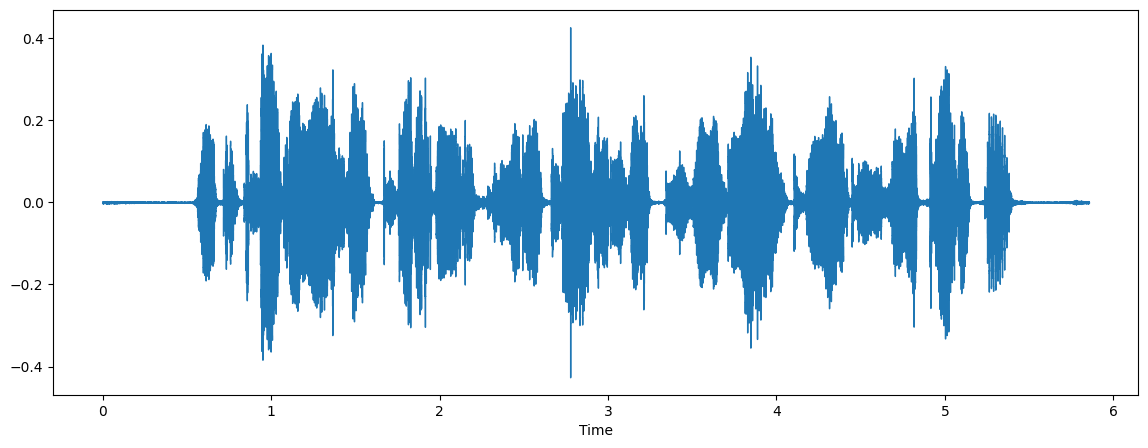

In [23]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

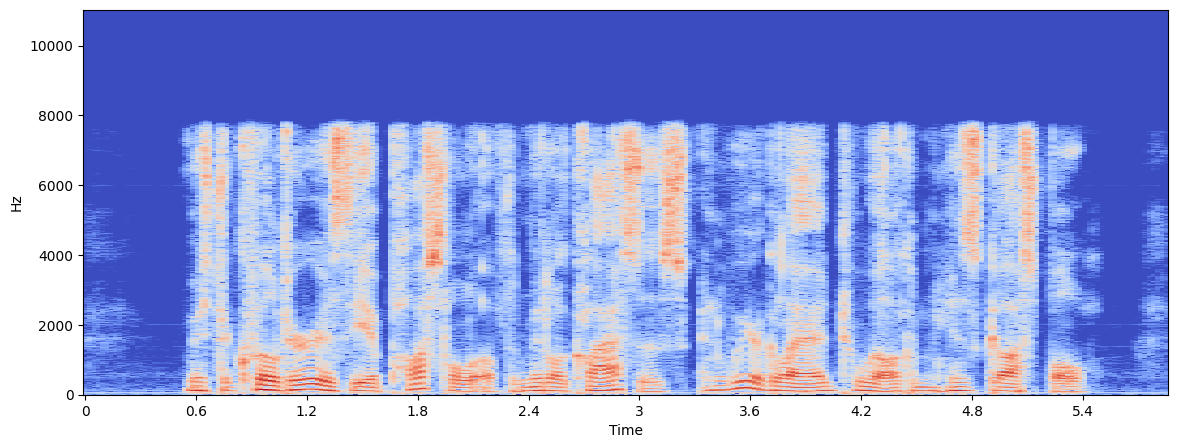

In [25]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

## Part 2: Transcribing long videos

In [32]:
import soundfile as sf

In [38]:
speech, sr = sf.read("/Users/hardiksahi/Personal/Preg/Audio/wav/16000Khz/Labour1 Apr 22 - Part A1.wav")

In [40]:
speech.shape

(62739593,)

In [41]:
long_pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=15, #long form transcription
    batch_size=16,
    torch_dtype=torch_dtype,
    device=device,
)

In [42]:
torch_dtype

torch.float16

In [43]:
result = long_pipe(speech)